In [157]:
# General
import glob, os
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import metrics
from pandas import crosstab
import re
from collections import Counter
import itertools
from itertools import cycle
import time

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from plotnine import *

# Feature engineering
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Modeling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from __future__ import print_function
from scipy.spatial.distance import cdist

# Unsupervised Capstone - Content classification

Nadine Ruecker<br>
February 2019

## Introduction

With the exponential generation of text files (tweets, newspaper, blogs,emails,books...), and the digitalization of handwritten documents from the past (reports, doctors notes,...), computer based summarization and automated classification have become essential tools do generate human digestable forms of this data.Natural language processing is the core of the summarization techniques.


## Aim

Here I have chosen ~1600 documents from several different categories that I would like to classify using different NLP techniques.The documents originate from textfiles.com and have been collected by sampling different categories on this website: Fiction, law, survival, programming, science and occult.<br>
This capstone project aims to:

1. Extract features from the documents using bag of words, term frequency inverse document frequency and parts of speech methods.
2. Cluster the features to explore the characteristics of the data.
3. Predict text categories on three different levels.
4. Using content similarity to recommend texts that cover a similar topic.
5. Adding tags to the data to summarize their content.


## Result Summary

The documents originate from textfiles.com and have been collected by sampling different categories on this website. We can differentiate the data on three diffrent levels:<>
1. Cat1: Fiction and non-fiction. 
2. Cat2: Fiction, law, survival, programming, science and occult. 
3. Subclass: Atheism, bob, christian, eris, freemansonry,jedi and unspecific.<br>
Only occult documents can further be divided into the 7 subclass categories.<br>
After extracting the author and title from the file description, the texts are cleaned from weird punctuation and shortened to 100.000 words if longer. Features are extracted using bag-of-words (BOW) lemmatization, term frequency inverse document frquency (tfidf) combined with single value decomposition (svd) and using parts-of speech (POS) extraction. BOW and TFIDF are performed on text level. The POS extraction was performed on sentence level. All sentences per book were than averaged. 
![Clusters form by two highest variance components: BOW, Tfidf, POS](Three feature plots.jpg)
As see in the figure above, BOW and tfidf yield features (left and middle graph) that differentiate the different text classes well into the 6 subclasses: With fiction and law being the most extrem values and everything else partially overlapping in between those two extremes. Unexpectedly, POS (right most graph) however did not yield specific cluster patterns and was not further used from there on. Probably, the specific differences especially in scientific and law texts I had expected, were softened by averaging oer complete books.<br>
If this dataset would have been unlabeled, it would have been great to use the generated features to classify the documents further. An unsupervised approach for this challenge is clustering. As we observe this partial overlap at the intersection of law and fiction, I was wondering how many clusters would be 'optimal' from a machine standpoint. 
![ELbow method](Elbow method.JPG)
Using silhouette score analysis for a range of up to 50 clusters, 5 actually seem to be the optimum. 
![Reproducibility of the clustering](Clustered data.JPG)
The clustering algorithm reproduced similar cluster distribution for both the training and the test set. 
![Crosstable](Crosstab.JPG)
As seen in this crosstable comparing the assigned clusters with the ground truth indicated that all documents in the intersection were clustered together.<br>
Clustering was not abled to differentiate the 6 different subcategories of documents, so would modelling be? In a first attempt I tested 8 different algorithms, the majority with a gridsearch to try several parameters. A multilayered perceptron failed, as it could not converge.
![Models tried](Models tried.JPG)
Logistic regression with ridge regularization performed best. I thought that the addition of binarized author data would further increase the accuracy, but this was unfortunatly not the case. 
![CF Cat2](CF Cat2.JPG)
The accurancy for the different subcategories varied and was worse for the 'science'(0.67) and 'survival' (0.64) categories in the intersection of law and fiction. 
![CF Cat1](CF Cat1.JPG)
The accuracy for differentiating fiction from non-fiction and non-fiction from fiction was 0.87 and 0.95, respectively.Even the subcategories of the occult subcategories were classified pretty succesfully even though for some there are only 5-10 documents included in the test set.<br>
But the documents can be classified even further: each lsa_features could basically demonstrate a certain set of documents, not excluding that other lsa_feature also further classify a document. A cosine similarity matrix was calculated based on the tfidf features, to recommend documents with similar content. Asking the algorithm, to return documents that are similar to 'The adventures of Aladdin', return decent results.<br>
![recommendations for Aladin](Aladdin recommendations.JPG)
I further used the top3 bow lemma to tag the documents, which can provide a summarization of the content. 
296 documents could be classified into 67 different tag classes, with computer classifying over 40 documents, followed by police, law and file.
![top tags](top tags.JPG)

In general this workflow demonstrates how bow and tfidf can be used to generalize the content of documents. Using more than one tag, the combination of words could have been used to classify even an unlabeled dataset into documents covering similar topics.

# Data exploration

In [2]:
overview= pd.read_csv('texts_all.csv')
overview.head()

,Cat1,Cat2,Filename,Size,Description of the Textfile,Subclass
0,fiction,fiction,100west.txt,20839,Going 100 West by 53 North by Jim Prentice (1990),NaN
1,fiction,fiction,13chil.txt,8457,The Story of the Sly Fox,NaN
2,fiction,fiction,14.lws,5261,A Smart Bomb with a Language Parser,NaN
3,fiction,fiction,16.lws,15294,"Two Guys in a Garage, by M. Peshota",NaN
4,fiction,fiction,17.lws,10853,The Early Days of a High-Tech Start-up are Mag...,NaN


In [3]:
# make sure we only use text once
overview= overview.drop_duplicates()

In [4]:
overview.groupby('Cat1').count()

,Cat2,Filename,Size,Description of the Textfile,Subclass
Cat1,,,,,
fiction,452,452,452,452,0
non-fiction,2065,2065,2065,2065,1010


In [5]:
overview.groupby('Cat2').count()

,Cat1,Filename,Size,Description of the Textfile,Subclass
Cat2,,,,,
fiction,452,452,452,452,0
law,533,533,533,533,0
occult,1010,1010,1010,1010,1010
programming,267,267,267,267,0
science,149,149,149,149,0
survival,106,106,106,106,0


In [6]:
overview.groupby('Subclass').count()

,Cat1,Cat2,Filename,Size,Description of the Textfile
Subclass,,,,,
atheisms,11,11,11,11,11
bob,52,52,52,52,52
christian,170,170,170,170,170
eris,74,74,74,74,74
freemansonry,23,23,23,23,23
jedi,5,5,5,5,5
unspecific,675,675,675,675,675


In [7]:
# get length of each document
numberoftextfiles=0
wordcounts=[]
title=[]

for file in glob.glob('stories\*'):
    #print(file)
    try:
        file_object = open(file, 'r') 
        text=file_object.read()
        #print(len(text))
        wordcounts.append(len(text))
        title.append(file.split('\\')[1])
        numberoftextfiles=numberoftextfiles+1
    except:
        pass
print("There are ", numberoftextfiles,"text files in total.")
print("The shortest text has ", min(wordcounts)," words.")
print("The longest text has ", max(wordcounts)," words.")

There are  1652 text files in total.
The shortest text has  207  words.
The longest text has  2588296  words.


In [8]:
#Function to extract publishing year
#r'\((\d{4})\)$'
def get_year(name):
    return re.search(r"\({4\d}\)", name).groups()[0]

In [9]:
#a='adam poszar (1990)'
#regex = r'\(\d{4}\)'
#regex in a.split()

In [287]:
chosentext=pd.DataFrame()
chosentext['Filename']=title
chosentext['length']=wordcounts

# add the title of the books from the original table
df=chosentext.merge(overview,on='Filename')
df['Description of the Textfile']= df['Description of the Textfile'].str.lower()
# extract the author and titles
Authors=[]
Titles=[]


def get_year(name):
    return re.search(r"\(\d{4}\)", name).groups(0)

for i, des in enumerate(df['Description of the Textfile']):
    if 'by' in des:
        Author= des.split('by')[1]
        Authors.append(Author)
        Title=des.split('by')[0]
        Titles.append(Title)
    else:
        Authors.append('unknown')
        Titles.append(des)  
    
df['Author']=Authors
df['Title']=Titles

#df=df.drop('Description of the Textfile', axis=1)
df.groupby('Author').count().sort_values('Filename', ascending=False).head()


,Filename,length,Cat1,Cat2,Size,Description of the Textfile,Subclass,Title
Author,,,,,,,,
unknown,887,887,887,887,887,887,141,887
m.j. malone,10,10,10,10,10,10,0,10
gay bost,8,8,8,8,8,8,0,8
"sam kitterman, jr.",5,5,5,5,5,5,0,5
e. cromwell mensch,5,5,5,5,5,5,5,5


In [11]:
# How many different authors?
# Clean up the author names
df= df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # remove all white space
df['Author']=df['Author'].str.replace('george e. dvorchak, jr., m.d.','george e. dvorchak jr. m.a., m.d.')
df['Author']=df['Author'].str.replace('thomas icom/iirg/cybertek','thomas icom')
df['Author']=df['Author'].str.replace('james a. huff','james a huff')
df['Author']=df['Author'].str.replace('don m. johnson of the fbi','don m. johnson')
df['Author']=df['Author'].str.replace('francis w. porretto of horse feathers bbs','francis w. porretto')
df['Author']=df['Author'].str.replace('g. drawyne fuselier','g. dawyne fuselier')
df['Author']=df['Author'].str.replace('g.i. joe of detac','g.i. joe')
df['Author']=df['Author'].str.replace('john gales sauls of the fbi academy','john gales sauls')
df['Author']=df['Author'].str.replace('martin r. crim  #4','martin r. crim')
df['Author']=df['Author'].str.replace('martin r. crim  part ii','martin r. crim')
df['Author']=df['Author'].str.replace('martin r. crim  part iii','martin r. crim')
df['Author']=df['Author'].str.replace('mitchell kapor of the eff','mitchell kapor')
df['Author']=df['Author'].str.replace('mitch kapor','mitchell kapor')
df['Author']=df['Author'].str.replace('night stalker of rage technologies','night stalker')
df['Author']=df['Author'].str.replace('patrick y lee','patrick y. lee')
df['Author']=df['Author'].str.replace('paul c. ricks of colorado springs p.d.','paul c. ricks')
df['Author']=df['Author'].str.replace('r. roger breton and nacy j. creek','r. roger breton and nancy j. creek')
df['Author']=df['Author'].str.replace('roy a.c. ramm','roy a. c. ramm')
df['Author']=df['Author'].str.replace('thomas v. kukura of the fbi','thomas w. kukura')

df['Author'] = np.where(df['Title'].str.contains("corbin"), "david r. corbin", df['Author'])

df['Author']=df['Author'].str.replace(r"\(.*\)","") # Remove everything in parenthesis
df['Author']=df['Author'].str.replace(r"\,.*","") # Remove everything after a comma
df['Author']=df['Author'].str.replace(r"\:.*","") # Remove everything after a colon

# Now that the authors are cleaned up let's remove duplicates again
df= df.drop_duplicates()
df.groupby('Author').count().sort_values('Filename', ascending=False)

#df.to_csv('texts_all_overview.csv')

,Filename,length,Cat1,Cat2,Size,Subclass,Title,Published
Author,,,,,,,,
unknown,876,876,876,876,876,141,876,876
kurt saxon,12,12,12,12,12,0,12,12
david r. corbin,11,11,11,11,11,0,11,11
m.j. malone,10,10,10,10,10,0,10,10
gay bost,8,8,8,8,8,0,8,8
william s. sessions,6,6,6,6,6,0,6,6
william s. burroughs,5,5,5,5,5,0,5,5
sam kitterman,5,5,5,5,5,0,5,5
e. cromwell mensch,5,5,5,5,5,5,5,5


Text(0.5, 1.0, 'Textlength')

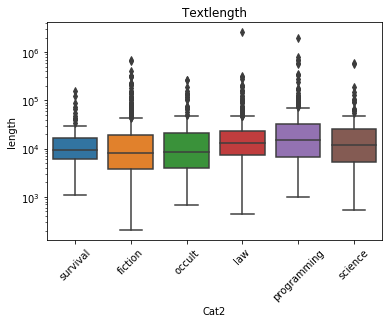

In [12]:
# plot the text word count
g=sns.boxplot(data=df,x='Cat2',y='length')
g.set_yscale('log')
plt.xticks(rotation=45)
plt.title('Textlength')

In [13]:
df.length.describe()

count    1.665000e+03
mean     2.985635e+04
std      1.003620e+05
min      2.070000e+02
25%      5.280000e+03
50%      1.149300e+04
75%      2.290400e+04
max      2.588296e+06
Name: length, dtype: float64

The texts have an average length of 30k words, with some outlayers with more than 100k words. To facilitate an even comparison, I will shorten all objects larger than 100k words. From objects larger than 100k words, I will combine the first 25k, the middle 50k and the last 25k words.

In [14]:
# How many text will be shorted?
print('Number of documents with more than 100k words:', df['length'][df['length']>100000].count(),".")

Number of documents with more than 100k words: 88 .


## Data exploration summary 

This is a diverse set of ~1600 documents. They can be classified into two major groups of documents: Non-fiction (1200) and fiction (~400 documents). The fiction class is not further categorized, but in the non-fiction class we can differentiate documents from 5 different fields: occult(1010), law (533), science (149), survival(106) and programming(267). There is a third subcategory for the texts covering religion (atheisms(11),bob(52),christian(170),eris(74),freemansonry(23),jedi(5),unspecific(675).<br>
88 documents are longer than 100k words, those are not processed fully and are broken into three pieces (first 25k, middle 50k, last 25k words).

# Feature extraction

In [15]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub(r'Ä',' ',text) 
    text = re.sub(r'Ú',' ',text)
    text = re.sub(r'¿',' ',text)
    text = re.sub(r'³',' ',text)
    text = re.sub(r'==',' ',text)
    text = re.sub(r'-=',' ', text)
    text = re.sub(r'~~',' ',text)
    text = re.sub(r'\*',' ',text)
    text = re.sub(r'&&',' ',text)
    text = re.sub(r'íí',' ',text)
    text = re.sub(r'\\X00',' ',text)
    text = re.sub(r'x00',' ',text)
    text = re.sub(r'ßß',' ',text)
    text = re.sub(r'','',text)
    text = re.sub(r'À',' ',text)
    text = re.sub(r'Ù',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    text = text.replace(r'\n+','').replace('\r+', '')
    text = re.sub(r"\(.*\)","",text) # Remove everything in parenthesis
    text = text.lower()
    return text

In [16]:
# extract text of files with regular length
regdf=df[df.length<100000]

content=[]
folder="stories\\"

for i,file in enumerate(regdf.Filename):
    file_object = open(folder+file, 'r') 
    text=file_object.read()
    text=text_cleaner(text)
    content.append(text)
regdf['Content']=content

# Shorten the logest 6 files
longfiles=df[df.length>100000]
content=[]


for i,file in enumerate(longfiles.Filename):
    file_object = open(folder+file, 'r') 
    text=file_object.read()
    middle=int(len(text)/2)
    t1= text[:25000]
    t2=text[middle:middle+50000]
    t3=text[len(text)-25000:len(text)]
    text=t1+t2+t3
    #print(type(text))
    text=text_cleaner(text)
    text=text.replace(r'\n+','').replace('\r+', '') #removing new line characters
    content.append(text)
longfiles['Content']=content

# combine them
print(regdf.shape)
cont_df=regdf.append(longfiles, ignore_index=True)
print(cont_df.shape)
cont_df.head()

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1577, 10)
(1665, 10)


,Filename,length,Cat1,Cat2,Size,Subclass,Author,Title,Published,Content
0,10-essnt.txt,11025,non-fiction,survival,11223,NaN,scott stoddard,"the ten essentials of survival,",unknown,"the ten essentials by scott stoddard ""don't le..."
1,100dying.asc,9579,non-fiction,survival,9827,NaN,tim clark,"100 ways to avoid dying,",unknown,242-9346 page 4
2,100west.txt,20423,fiction,fiction,20839,NaN,53 north,going 100 west,unknown,"this is a shareware trial project it is not ""f..."
3,117.txt,8018,non-fiction,survival,8192,NaN,the red cross,"treating for cold exposure, from a booklet",unknown,treating for cold exposure and frostbite the f...
4,118.txt,8536,non-fiction,survival,8704,NaN,the red cross,"treating for shock,",unknown,treating for shock the following material may ...


## Testset

In [17]:
import random
# define random state for reproducible experiments
np.random.seed(123)

# Choose ~1/4 from each subcategory as testset
filesfortestset=[]
for Cat2 in df.Cat2.unique():
    df_Cat2=df[df.Cat2==Cat2]
    allfiles=df_Cat2.Filename.tolist()
    chosen_files=random.sample(allfiles,int(df_Cat2.shape[0]/4)) #choose 1/4 from each group
    filesfortestset.append(chosen_files)
flat_testfile_list = [item for sublist in filesfortestset for item in sublist]
len(flat_testfile_list)

# Generate the test data set
test_df=cont_df[cont_df['Filename'].isin(flat_testfile_list)]
test_df= test_df.reset_index()
print('Testset shape:', test_df.shape)

# Generate the training dataset
train_df=cont_df[~cont_df['Filename'].isin(flat_testfile_list)]
train_df=train_df.reset_index()
print('Trainset shape:', train_df.shape)

Testset shape: (421, 11)
Trainset shape: (1244, 11)


## Fuctions

In [18]:
# Tokenization of document
def bag_of_words(text, NumberOfWordsToReturn):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(NumberOfWordsToReturn)]

## Bag of words

In [19]:
# looping through each text,and extracting the mostcommon 2000 words
nlp = spacy.load('en')
words_list=[]

#getting the unique words from the mostcommon words of all documents
for i, content in enumerate(train_df.Content):
    #progress tracker
    if i%50==0:
        print('Processing book',i+1, '-', i+50)
    doc= nlp(content)
    # Extact the 2000 most common words
    words= bag_of_words(doc, 2000)
    words_list.append(words) 
flat_list = [item for sublist in words_list for item in sublist]
print(len(flat_list))
commonwords=set(flat_list)

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
Processing book 451 - 500
Processing book 501 - 550
Processing book 551 - 600
Processing book 601 - 650
Processing book 651 - 700
Processing book 701 - 750
Processing book 751 - 800
Processing book 801 - 850
Processing book 851 - 900
Processing book 901 - 950
Processing book 951 - 1000
Processing book 1001 - 1050
Processing book 1051 - 1100
Processing book 1101 - 1150
Processing book 1151 - 1200
Processing book 1201 - 1250
268181


In [20]:
# DOES NOT WORK
#Safe the common words, so they don't have to be recalculated
#commonwords_df=pd.DataFrame(data=commonwords)
#commonwords_df.to_csv('commonwords.csv')

#file_object = open('BonkContent_commonwords.txt', 'r') 
#commonwords=file_object.read()
#print(type(commonwords))
#commonword_list=commonwords.split(',')
#print(type(commonword_list))
#commonword_list[]

In [21]:
# test the run time of bow_features for one of the long files
# Make a list of spcay docs.
def makeDoc_list(df):
    textdoc_list=[]

    for i, content in enumerate(df['Content']):
        text_doc=nlp(content)
        textdoc_list.append(text_doc)
        if i%50==0:
            print('Processing book',i+1, '-', i+50)
    print(type(textdoc_list[0]))
    print(len(textdoc_list))
    return(textdoc_list)

In [22]:
train_doc_list=makeDoc_list(train_df)

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
Processing book 451 - 500
Processing book 501 - 550
Processing book 551 - 600
Processing book 601 - 650
Processing book 651 - 700
Processing book 701 - 750
Processing book 751 - 800
Processing book 801 - 850
Processing book 851 - 900
Processing book 901 - 950
Processing book 951 - 1000
Processing book 1001 - 1050
Processing book 1051 - 1100
Processing book 1101 - 1150
Processing book 1151 - 1200
Processing book 1201 - 1250
<class 'spacy.tokens.doc.Doc'>
1244


In [23]:
test_doc_list=makeDoc_list(test_df)

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
<class 'spacy.tokens.doc.Doc'>
421


In [24]:
# loop through the docs in the list and count how often each word appears
def getBOWFeatures(text_doc_list, commonwords):

    df_words = pd.DataFrame(columns=commonwords,index=range(len(text_doc_list)))
    df_words.loc[:, commonwords] = 0
    
    for i, text_doc in enumerate(text_doc_list):
        
        #progress tracker
        if i%50==0:
            print('Processing book',i+1, '-', i+50)
        #extract common words    
        words = [token.lemma_
                     for token in text_doc
                     if (not token.is_punct
                         and not token.is_stop
                         and token.lemma_ in commonwords
                     )]

        # Populate the row with the corresponding word counts.
        for word in words:
            #print(i, word, type(word))
            df_words.loc[i, word] += 1

    print("df shape: ",df_words.shape)
    return(df_words)

In [25]:
train_BOWFeatures= getBOWFeatures(train_doc_list,commonwords)

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
Processing book 451 - 500
Processing book 501 - 550
Processing book 551 - 600
Processing book 601 - 650
Processing book 651 - 700
Processing book 701 - 750
Processing book 751 - 800
Processing book 801 - 850
Processing book 851 - 900
Processing book 901 - 950
Processing book 951 - 1000
Processing book 1001 - 1050
Processing book 1051 - 1100
Processing book 1101 - 1150
Processing book 1151 - 1200
Processing book 1201 - 1250
df shape:  (1244, 40336)


In [41]:
train_BOWFeatures.to_csv('train_bow.csv')

In [26]:
test_BOWFeatures=getBOWFeatures(test_doc_list,commonwords)

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
df shape:  (421, 40336)


In [42]:
test_BOWFeatures.to_csv('test_bow.csv')

### BOW - PCA

Explained variance per component: [0.06480727 0.02620444 0.02057357 0.01499067 0.01186811 0.00993297
 0.00885487 0.00813042 0.00719537 0.00662837]
(1244, 527)


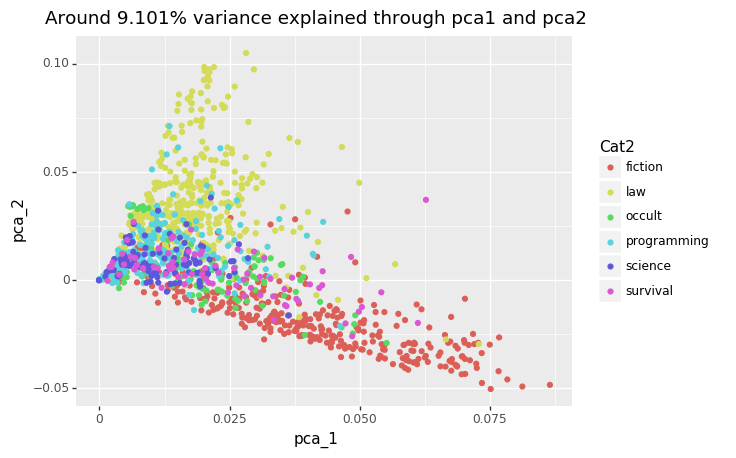

<ggplot: (146498211816)>

In [27]:
# run PCA over bow features to reduce dimensions
# Normalize
train_bow_norm = normalize(train_BOWFeatures)

pca = PCA(n_components=0.80,svd_solver = 'full')
pcas=pca.fit(train_bow_norm.T)
pcas_df = pd.DataFrame(data=pca.components_.T)
print('Explained variance per component:',pca.explained_variance_ratio_[0:10])

# Add columns names
n_pcas=pcas_df.shape[1]

columnsN=[]
for i in range(n_pcas):
    columnsN.append('pca_'+str(i+1))


pcas_df.columns=columnsN
pcas_df['Cat1']=train_df.Cat1
pcas_df['Cat2']=train_df.Cat2
pcas_df['Subclass']=train_df.Subclass
pcas_df['Author']=train_df.Author
pcas_df['Title']=train_df.Title
pcas_df['Length']=train_df.length
pcas_df['Filename']=train_df.Filename
print(pcas_df.shape)

expVar12=round((pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100,3)
Title='Around '+ str(expVar12) +'% variance explained through pca1 and pca2'
(ggplot(pcas_df)
 + geom_point(aes(x='pca_1', y='pca_2', color='Cat2'))
 + labs(title=Title)
)


In [40]:
pcas_df.to_csv('pcas_df.csv')

## Tfidf features

In [28]:
train_Content_list=train_df['Content'].tolist()
test_Content_list=test_df['Content'].tolist()

#Initiate the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than 50% of all the paragraphs
                                min_df=3, # only use words that appear at least 4 times
                                stop_words='english', 
                                lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                                use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                                norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                ngram_range=(1, 2) # include 1,2 word combinations
                            )

# Fit the vectorizer using the training set
train_tfidf=vectorizer.fit_transform(train_Content_list)
print("Number of features: %d" % train_tfidf.get_shape()[1])
#Applying the vectorizer to the test data
test_tfidf=vectorizer.transform(test_Content_list)

Number of features: 24541


In [84]:
#Our SVD data reducer. .
svd= TruncatedSVD(n_components=300)
lsa = make_pipeline(svd, Normalizer(copy=False))
train_lsa_features = lsa.fit_transform(train_tfidf)
print("Number of features after svd:", train_lsa_features.shape[1])

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

results=pd.DataFrame()
results['svd']=range(300)
results['variance']=svd.explained_variance_ratio_
results=results.sort_values('variance',ascending=False)
print(results.head())

# transform the test dataset
test_lsa_features = lsa.transform(test_tfidf)

Number of features after svd: 300
Percent variance captured by all components: 49.806671529770426
   svd  variance
1    1  0.011781
2    2  0.008956
0    0  0.008470
3    3  0.007630
4    4  0.007129


In [ ]:
# Exploring the first component 
lsa_df[['lsa_1','Author','Title']].sort_values(['lsa_1'], ascending=False).head()

### TFIDF - SVD

(1244, 307)


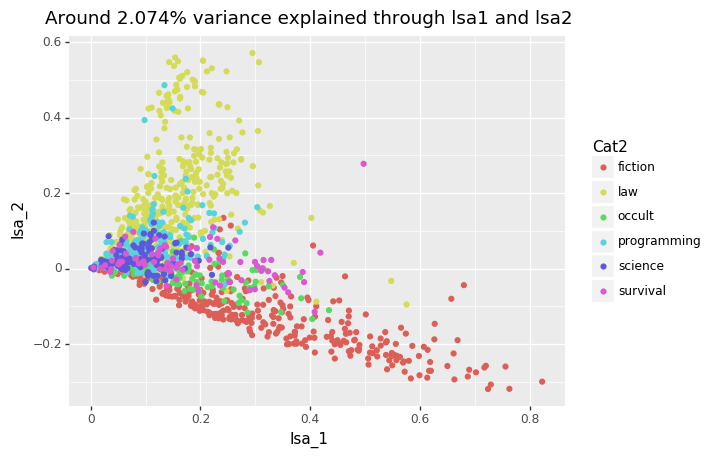

<ggplot: (146453280653)>

In [30]:
# Make a new df to store the new features
lsa_df=pd.DataFrame(data=train_lsa_features)

# Add columns names
n_lsa=lsa_df.shape[1]

columnsN=[]
for i in range(n_lsa):
    columnsN.append('lsa_'+str(i+1))


lsa_df.columns=columnsN
lsa_df['Cat1']=train_df.Cat1
lsa_df['Cat2']=train_df.Cat2
lsa_df['Subclass']=train_df.Subclass
lsa_df['Author']=train_df.Author
lsa_df['Title']=train_df.Title
lsa_df['Length']=train_df.length
lsa_df['Filename']=train_df.Filename
print(lsa_df.shape)

expVar12=round((results.variance.iloc[0]+results.variance.iloc[1])*100,3)
Title='Around '+ str(expVar12) +'% variance explained through lsa1 and lsa2'
(ggplot(lsa_df)
 + geom_point(aes(x='lsa_1', y='lsa_2', color='Cat2'))
 + labs(title=Title)
)

In [36]:
# Exploring the first component 
lsa_df[['lsa_1','Author','Title', 'Cat2']].sort_values(['lsa_1'], ascending=False).head()

,lsa_1,Author,Title,Cat2
522,0.821930,cac/the stinker,forgotten souls,fiction
971,0.762333,unknown,story: running,fiction
95,0.755171,unknown,"arcadia, a story",fiction
426,0.728511,unknown,the adventure of the engineer's thumb,fiction
499,0.723351,l. shawn aiken,"beacons of light,",fiction


In [37]:
# Farthest away from fiction is computer crime
# Exploring the first component 
lsa_df[['lsa_2','Author','Title','Cat2']].sort_values(['lsa_2'], ascending=False).head()

,lsa_2,Author,Title,Cat2
270,0.571749,unknown,"computer crime: current practices, problems an...",law
701,0.559846,unknown,"kansas computer crimes law, 1985",law
100,0.551862,unknown,"arkansas regulations on computer crime, 1987",law
782,0.551215,unknown,the minnesota computer crimes law,law
963,0.549858,unknown,"rhode island computer crimes law, 1979",law


In [39]:
lsa_df.to_csv('lsa_df.csv')

## Parts of speech features

To analyse the composition of part of speech features, the books were analysed on the sentence level. To generate features that can be combined with the previous datasets, the sentences results are then averaged per book.

In [31]:
def pos_features(sentences):
    
    possiblePOS=['POS','ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM',
             'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']
    df_sent = pd.DataFrame(sentences)
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=possiblePOS)
    df['text_sentence'] = df_sent[0]
    #df['text_source'] = df_sent[1]
    df.loc[:, possiblePOS] = 0
    
    # Process each row, counting the occurrence of POS in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        # Convert the sentence to doc and then extract all pos
        str_sent = str(sentence)
        doc = nlp(str_sent)
        for token in enumerate(doc):
            #print('token: ',token[1])
            #print('token_pos: ',token[1].pos_)
            poss = [token.pos_ for token in doc]
        
        # Populate the row with pos counts.
        for pos in poss:
            df.loc[i, pos] += 1
    
    # replace all NaN with 0  
    df=df.fillna(0) 

    # some more features
    df['NounsNonNounsRatio']=df['NOUN']/df.sum(axis=1)
    df['NounsVerbsRatio']=df['NOUN']/(df['NOUN']+df['VERB'])
    df['ADJ+ADVRatio'] = (df['ADJ']+df['ADV'])/df.sum(axis=1)
    
    # Fix some issues of the df
    df=df.fillna(0) # replace all NaN with 0
    return df

In [32]:
train_doc_df=pd.DataFrame()
train_doc_df['Doc']=train_doc_list
train_doc_df['Author']=train_df.Author
train_doc_df['Title']=train_df.Title
train_doc_df['Length']=train_df.length
train_doc_df['Filename']=train_df.Filename
train_doc_df.head()

,Doc,Author,Title,Length,Filename
0,"( , 242, -, 9346, page, 4)",tim clark,"100 ways to avoid dying,",9579,100dying.asc
1,"(this, is, a, shareware, trial, project, it, i...",53 north,going 100 west,20423,100west.txt
2,"(treating, for, cold, exposure, and, frostbite...",the red cross,"treating for cold exposure, from a booklet",8018,117.txt
3,"(treating, for, shock, the, following, materia...",the red cross,"treating for shock,",8536,118.txt
4,"(13013, =, bob, ;, b, =, 2, ,, b, =, 2, ;, o, ...",unknown,"numerology of the proof of ""bob""",1615,13013.txt


In [33]:
len(train_doc_list)

1244

In [43]:
# For each text_doc in text_doc_list

POSwithAdditions=['POS','ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM',
             'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE','NounsNonNounsRatio',
                 'NounsVerbsRatio','ADJ+ADVRatio']
pos_df=pd.DataFrame(columns=POSwithAdditions, index=range(len(train_doc_list)))

i=0
for text_doc in train_doc_list:
    book_sentences=[sent for sent in text_doc]
    book_pos=pos_features(book_sentences)
    averagePOS=book_pos.describe().iloc[1,:]
    pos_df.iloc[i,:]=averagePOS
    if i%50==0:
            print('Processing book',i+1, '-', i+50)
    i=i+1
print(pos_df.shape)
pos_df.head()

Processing book 1 - 50
Processing book 51 - 100
Processing book 101 - 150
Processing book 151 - 200
Processing book 201 - 250
Processing book 251 - 300
Processing book 301 - 350
Processing book 351 - 400
Processing book 401 - 450
Processing book 451 - 500
Processing book 501 - 550
Processing book 551 - 600
Processing book 601 - 650
Processing book 651 - 700
Processing book 701 - 750
Processing book 751 - 800
Processing book 801 - 850
Processing book 851 - 900
Processing book 901 - 950
Processing book 951 - 1000
Processing book 1001 - 1050
Processing book 1051 - 1100
Processing book 1101 - 1150
Processing book 1151 - 1200
Processing book 1201 - 1250
(1244, 23)


,POS,ADJ,ADP,ADV,AUX,CONJ,CCONJ,DET,INTJ,NOUN,...,PROPN,PUNCT,SCONJ,SYM,VERB,X,SPACE,NounsNonNounsRatio,NounsVerbsRatio,ADJ+ADVRatio
0,0,0,0,0,0,0,0,0,0,0.166667,...,0,0.333333,0,0,0,0,0.166667,0.166667,0.166667,0
1,0,0.0906794,0.135036,0.0395845,0,0,0.0404267,0.105839,0.00421112,0.264458,...,0.00112296,0.131668,0,0,0.14767,0.000842223,0.000280741,0.264458,0.264458,0.130264
2,0,0.130631,0.133634,0.0570571,0,0,0.0525526,0.0780781,0.0045045,0.228228,...,0,0.111111,0,0,0.174174,0.00750751,0.0015015,0.228228,0.228228,0.187688
3,0,0.0917722,0.155063,0.0348101,0,0,0.028481,0.0791139,0.00316456,0.297468,...,0,0.14557,0,0,0.142405,0.00316456,0.00316456,0.297468,0.297468,0.126582
4,0,0.038674,0.132597,0.0220994,0,0,0.0276243,0.0497238,0.0165746,0.18232,...,0.00552486,0.270718,0,0,0.0828729,0.0662983,0,0.18232,0.18232,0.0607735


In [44]:
# Plotting the Pos features with the most variance, to see if they would make a could feature for differentiation
pos_df.to_csv("pos_df.csv")
pos_df=pos_df.apply(pd.to_numeric)

# Extract the std from each row and sort them
pos_df.describe().iloc[2,:].sort_values(ascending=False).head()

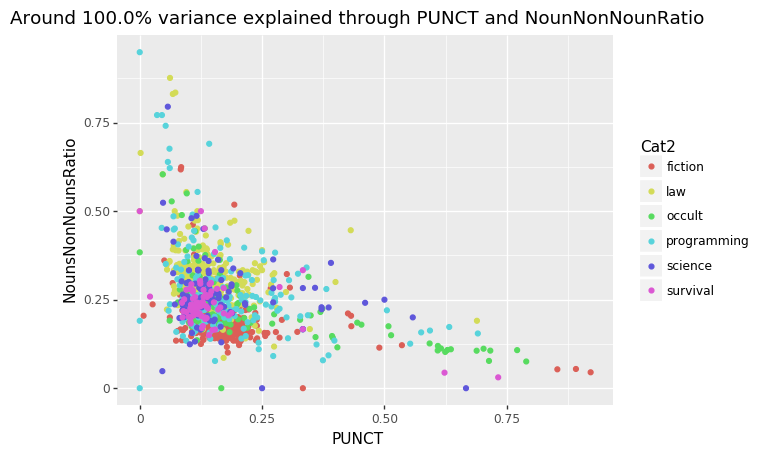

<ggplot: (146713588039)>

In [285]:
# Punctuation and NounsNonNounsRatio have the highest variance
variance_list=(pos_df.describe().iloc[2,:]*pos_df.describe().iloc[2,:]).sort_values(ascending=False)
Totalvariance=variance_list.sum()
#print(Totalvariance)
var1=variance_list[0]/Totalvariance
var2=variance_list[1]/Totalvariance
#print(var1)
#print(var2)
expVar=var1 +var2
#print(expVar)

pos_df['Cat1']=train_df.Cat1
pos_df['Cat2']=train_df.Cat2
pos_df['Subclass']=train_df.Subclass
pos_df['Author']=train_df.Author
pos_df['Title']=train_df.Title
pos_df['Length']=train_df.length
pos_df['Filename']=train_df.Filename

expVar12=round((var1 +var2)*100,3)
Title='Around '+ str(expVar12) +'% variance explained through PUNCT and NounNonNounRatio'
(ggplot(pos_df)
 + geom_point(aes(x='PUNCT', y='NounsNonNounsRatio', color='Cat2'))
 + labs(title=Title)
)

## Priliminary findings of the feature extraction
When plotting the very high dimensional data in only two dimensions, as observed in the previous sections, the texts seem to cluster into at least two different populations of texts: law and fictions. This was independently confirmed using bow followed by pca, tfidf followed by svd. At the intersection of those two populations we see the other groups overlapping, with texts from the science and programming category overlapping more with the law category and survival and occult texts more in the fiction area.
The two features with the highest percentage of variance for the part odf speech analysis, however seem to fail to generate clusters by text categories.<br>
In the following section, I will used Kmeans clustering algorithm to explore whether those categories can be differentiated using KMeans.
# Cluster analysis

## Determination of the number of clusters
As tfidf and bow provide very similar data distributions I will focus the cluster analysis only o the tfidf_svd data set. First, I will use the 'elbow' method to determine the optimal number of clusters. The distortion, the distance between the datapoints and the centroids will decrease with increasing numbers of clusters. The point at which the distortion stops to strink drastical (the elbow), indicates the 'optimal' number of clusters.

In [70]:
lsa_df_clust=lsa_df.iloc[:,:300]

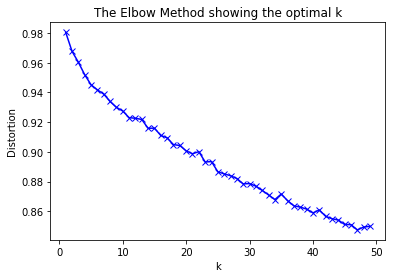

In [73]:
#Source:https://pythonprogramminglanguage.com/kmeans-elbow-method/
# k means determine k
distortions = []

X=lsa_df.iloc[:,:300]

K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

It looks as if there is an elbow at 5 clusters. Let's see how those clusters overlap with our actual classes.

## Reconfirm k using KMeans


In [107]:
# Check the 5 clsuter solution for the test and the training data set
train_data=lsa_df.iloc[:,:300]
test_data = test_lsa_df.iloc[:,:300]
km = KMeans(n_clusters=5)

KM_train=km.fit_predict(train_data)
#train_labels=KM_train.labels_
KM_test=km.predict(test_data)
#test_labels=KM_test.labels_


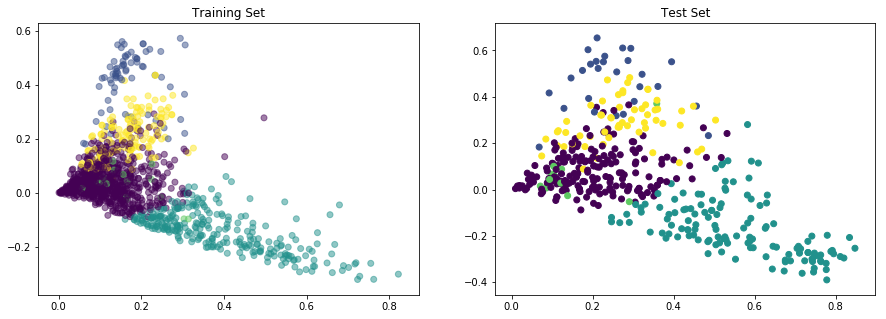

In [108]:
# plot the results of the KMeans Clustering using the first 2 lsa components 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(train_data.iloc[:, 0], train_data.iloc[:, 1], c=KM_train, alpha=0.5)
plt.title('Training Set')

plt.subplot(1,2,2)
plt.scatter(test_data.iloc[:, 0], test_data.iloc[:, 1], c=KM_test)
plt.title('Test Set')


plt.show()

In [236]:
# cross tab to compare the actual 6 groups against the 5 cluster groups
crosstab(KM_train,train_df.Cat2)

Cat2,fiction,law,occult,programming,science,survival
row_0,,,,,,
0,99,173,112,189,101,59
1,0,66,0,4,0,0
2,232,7,15,0,0,17
3,6,3,3,1,7,3
4,0,147,0,0,0,0


## Clustering results

The elbow methods suggested an optimal number of 5 clusters. The cluster generated nicely recapitulate the actual clusters. The clustering seems stable as the clusters show a simiar distribution when using the testset.

# Predicting text categories

The lsa data is used for modeling the data categories, because the pos data failed to show any strong relationship to the actual document categories. 
## Functions

In [115]:
def CheckSenandSpe(Name,model,input_df,target,no_folds):
    y_pred = cross_val_predict(model,input_df,target,cv=no_folds)
    tn, fp, fn, tp = confusion_matrix(target,y_pred).ravel()
    
    print(Name)
    print()
    print('True Positives:',tp)
    print('False Negatives:',fn)
    
    Sensitivity=tp/(tp+fn)*100
    print('Sensitivity:',round(tp/(tp+fn)*100,3))
    print()
    print('True Negatives:',tn)
   
    print('False Positives:',fp)
    Specificity=tn/(tn+fp)*100
    print('Specificity:',round(tn/(tn+fp)*100))
    
    return(Sensitivity,Specificity)

In [116]:
def runNB(input_df, target, no_folds):
    start_time=time.time()
    nb = GaussianNB()
    #nb.fit(input_df, target)
    print('Naive Bayes')
    
    cvs = cross_val_score(nb, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [128]:
param_grid= {'n_estimators': [ 50,100,200, 500]}

In [138]:
def runRFC_class(input_df, target, no_folds):
    start_time=time.time()
    param_grid= {'n_estimators': [50,100,200,500]}
    print('Random Forest')
    rand_forest_class = ensemble.RandomForestClassifier()
    CV_model = GridSearchCV(estimator=rand_forest_class, param_grid=param_grid, cv= 5)
    
    CV_model.fit(input_df, target)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds) 
    print("Best parameters:", CV_model.best_params_) 
    #print('Feature Importance:{}',rand_forest_class.feature_importances_)
       
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [142]:
def runKNN_class(input_df, target,no_folds):
    start_time=time.time()
    param_grid= {'n_neighbors': [ 3,5,7,10]}
    print('KNN')
    knn_w = neighbors.KNeighborsClassifier(weights='distance')
    CV_model = GridSearchCV(estimator=knn_w, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_)
    # cross validation
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [143]:
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression()
    
    #logreg.fit(input_df, target)
    print('Logistic regression')
    #print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)

    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [144]:
def runLasso(input_df,target,no_folds):
    start_time=time.time()
    print('Lasso')
    param_grid = {'C': [ 0.1,0.5, 1,2,5, 10,100]}
    lasso = linear_model.LogisticRegression(penalty='l2')
    CV_model = GridSearchCV(estimator=lasso, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [179]:
def runRidge(input_df,target,no_folds):
    start_time=time.time()
    print('Ridge')
    param_grid = {'C': [ 0.1,0.5, 1,2,3,4,5, 10,100]}
    ridge = linear_model.LogisticRegression(penalty='l1')
    CV_model = GridSearchCV(estimator=ridge, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [146]:
def runSVM(input_df,target,no_folds):
    start_time=time.time()
    param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]}
    svm = SVC(kernel = 'linear') 
    CV_model = GridSearchCV(estimator=svm, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [147]:
def runMLP(input_df,target,no_folds): 
    param_grid = {'hidden_layer_sizes':[[100,500,20,4], [500,100,20,4], [200,100,20,4], [200,100,100,20]]}
    start_time= time.time()
    print('Multilayerd perceptron')
    mlp = MLPClassifier() 
    CV_model = GridSearchCV(estimator=mlp, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} minutes.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    runtime=time.time() - start_time
    print()
    return(cvs)

## Which model performs best?

In [213]:
X_train = lsa_df.iloc[:,:300]
Y_train = train_df.Cat2
X_test = test_lsa_df.iloc[:,:300]
Y_test = test_df.Cat2

In [150]:
cvs_NB=runNB(X_train, Y_train, 3)

Naive Bayes
Time taken: 0.078 seconds.
Average accuracy RFC: 0.746
Standard deviation of accuracy: 0.033



In [151]:
cvs_KNN=runKNN_class(X_train, Y_train, 3)

KNN
Best parameters: {'n_neighbors': 10}
Time taken: 45.815 seconds.
Average accuracy KNN with weights: 0.801
Standard deviation of accuracy: 0.028



In [152]:
cvs_RFC= runRFC_class(X_train, Y_train, 3)

Random Forest
Best parameters: {'n_estimators': 500}
Time taken: 200.033 seconds.
Average accuracy RFC: 0.829
Standard deviation of accuracy: 0.020



In [153]:
cvs_Logit= runLogit(X_train, Y_train, 3)

Logistic regression
Time taken: 0.625 seconds.
Average accuracy: 0.798
Standard deviation of accuracy: 0.030



In [154]:
cvs_Lasso= runLasso(X_train, Y_train, 3)

Lasso
Best parameters: {'C': 2}
Time taken: 22.857 seconds.
Average accuracy: 0.830
Standard deviation of accuracy: 0.028



In [155]:
cvs_Ridge= runRidge(X_train, Y_train, 3)

Ridge
Best parameters: {'C': 2}
Time taken: 35.788 seconds.
Average accuracy: 0.840
Standard deviation of accuracy: 0.033



In [158]:
cvs_SVM= runSVM(X_train, Y_train, 3)

Best parameters: {'C': 1}
Time taken: 92.177 seconds.
Average accuracy: 0.815
Standard deviation of accuracy: 0.037



In [178]:
# The algorithm did not find a minimum/did not converge within 200 iteration
#cvs_MLP= runMLP(X_train, Y_train, 3)

Text(0.5, 0, 'Models tried')

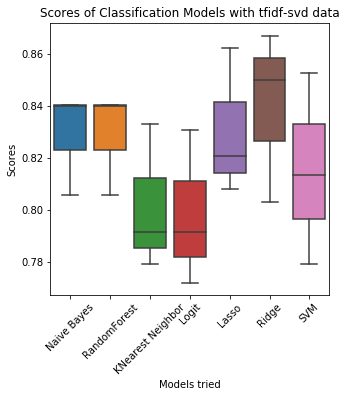

In [162]:
# Plot the results
Scores = {'Naive Bayes': cvs_RFC,
          'RandomForest': cvs_RFC,
          'KNearest Neighbor':cvs_KNN, 
          'Logit':cvs_Logit,
          'Lasso':cvs_Lasso,
          'Ridge':cvs_Ridge,
          'SVM':cvs_SVM}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45)
im.set_title('Scores of Classification Models with tfidf-svd data')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

## Improve accuracy

In [173]:
# Convert categorical data numeric
cols_to_transform= ['Author']
train_author_data = pd.get_dummies(train_df['Author'] ,columns = cols_to_transform)
X_train2 = pd.concat([X_train, train_author_data], axis=1)
#X_train2.head()
X_train2 =X_train2.apply(pd.to_numeric)

In [180]:
cvs_Ridge2= runRidge(X_train2, Y_train, 3)

Ridge
Best parameters: {'C': 2}
Time taken: 35.220 seconds.
Average accuracy: 0.833
Standard deviation of accuracy: 0.032



## Test set prediction

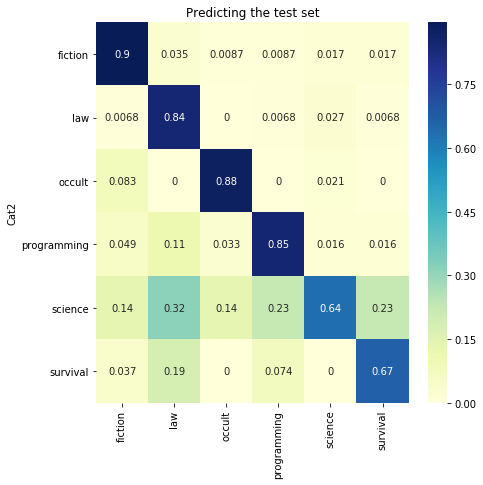

In [199]:
# test Ridge on the test set
ridge = linear_model.LogisticRegression(penalty='l1', C=2)
ridge.fit(X_train,Y_train)
y_predict=ridge.predict(X_test)

cm=crosstab(Y_test, y_predict)
# Convert into percentage
cm['RowSum']= cm.sum()
cm_p=pd.DataFrame()
cm_p['fiction']=cm['fiction']/cm.RowSum
cm_p['law']=cm['law']/cm.RowSum
cm_p['occult']=cm['occult']/cm.RowSum
cm_p['programming']=cm['programming']/cm.RowSum
cm_p['science']=cm['science']/cm.RowSum
cm_p['survival']=cm['survival']/cm.RowSum

# Plot persentage matrix
plt.figure(figsize=(7,7))
sns.heatmap(cm_p,cmap="YlGnBu", annot =True)
plt.title('Predicting the test set')
plt.show()

## Modeling results for Cat2

Testing a total of 8 models most of them with a gridsearch to finding optimal running parameters, showed that ridge regression yiels the highest accrucay scores. I tried to improve the model accuracy by adding the author information as well, but this did not yield to any improvement of the score. The text documents in the test set for correctly classify depending on the category. Fiction was classified correctly in 90% of the cases, law programming and occult were clssified correctly in 84-88% of the cases. Classifying science and survival documents demonstrated to be most difficult. The succesrate range between 64-67%. Both document classes are often apparently similar to law.

## Predicting fiction versus non-fiction

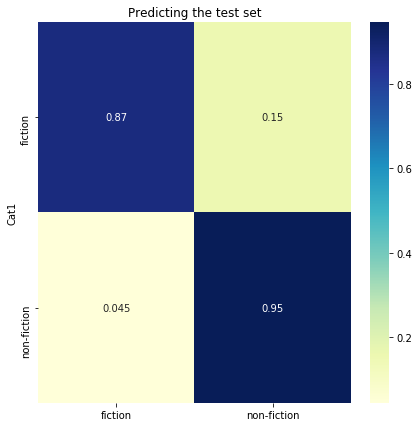

In [215]:
X_train_b = lsa_df.iloc[:,:300]
Y_train_b = train_df.Cat1
X_test_b = test_lsa_df.iloc[:,:300]
Y_test_b = test_df.Cat1


# test Ridge on the test set
ridge = linear_model.LogisticRegression(penalty='l1', C=2)
ridge.fit(X_train_b,Y_train_b)
y_predict_b=ridge.predict(X_test_b)

cm=crosstab(Y_test_b, y_predict_b)
# Convert into percentage
cm['RowSum']= cm.sum()
cm_p=pd.DataFrame()
cm_p['fiction']=cm['fiction']/cm.RowSum
cm_p['non-fiction']=cm['non-fiction']/cm.RowSum

# Plot persentage matrix
plt.figure(figsize=(7,7))
sns.heatmap(cm_p,cmap="YlGnBu", annot =True)
plt.title('Predicting the test set')
plt.show()

## Predict the subcategories of occult

In [209]:
# Subset the data

lsa_df_oc=lsa_df[lsa_df.Cat2=='occult']
X_train_oc = lsa_df_oc.iloc[:,:300]
train_df_oc = train_df[train_df.Cat2=='occult']
Y_train_oc = train_df_oc.Subclass

test_lsa_df_oc=test_lsa_df[test_lsa_df.Cat2=='occult']
X_test_oc = test_lsa_df_oc.iloc[:,:300]
test_df_oc = test_df[test_df.Cat2=='occult']
Y_test_oc = test_df_oc.Subclass


In [211]:
# test Ridge on the test set
ridge = linear_model.LogisticRegression(penalty='l1', C=2)
ridge.fit(X_train_oc,Y_train_oc)
y_predict_oc=ridge.predict(X_test_oc)

cm=crosstab(Y_test_oc, y_predict_oc)
cm

col_0,atheisms,bob,eris,freemansonry
Subclass,,,,
atheisms,3,0,0,0
bob,0,10,0,0
christian,0,0,1,0
eris,0,0,18,0
freemansonry,1,0,0,9
jedi,0,0,1,0
unspecific,0,1,1,2


Atleast the most aboundant subcategories of the occult section are predicted quite succesful. Unfortunately, the categories are not all available in the test set.
# Recommendation
Using cosine similarities of the lsa data, content based recommendation can be made.

In [216]:
lsa_df.iloc[:,:300].shape

(1244, 300)

In [217]:
# convert in
from scipy.sparse import *
from scipy import *
svd_lsa_csr=csr_matrix( (lsa_df.iloc[:,:300].values), shape=(1244,300) )
type(svd_lsa_csr)

scipy.sparse.csr.csr_matrix

In [ ]:
# Each entry in the song_docs list is a doc object corresponding to one song.
# Now compare the similarities between each song
import itertools

cosine_sim_matrix=np.zeros((lsa_df.iloc[:,:300].shape[0],lsa_df.iloc[:,:300].shape[0]))
index_list=range(lsa_df.iloc[:,:300].shape[0])

# Calculate the similarities
similarities=[]
for a, b in itertools.combinations(svd_lsa_csr, 2):
    a_vec=a.toarray()
    #print(type(a))
    b_vec=b.toarray()
    similarities.append(cosine_similarity(a_vec,b_vec))

#Need to flatten the similarity list, it contains nested arrays...so weird
flat_list=[]
for sublist in similarities:
    for item in sublist:
        flat_list.append(item)

flat_list2=[]
for sublist in flat_list:
    for item in sublist:
        flat_list2.append(item)

# determine the combinations
x_co=[]
y_co=[]
for a, b in itertools.combinations(index_list, 2):
    x_co.append(a)
    y_co.append(b)

# combine in a dataframe
sim_df=pd.DataFrame()
sim_df['sim']=flat_list2
sim_df['X']=x_co
sim_df['Y']=y_co

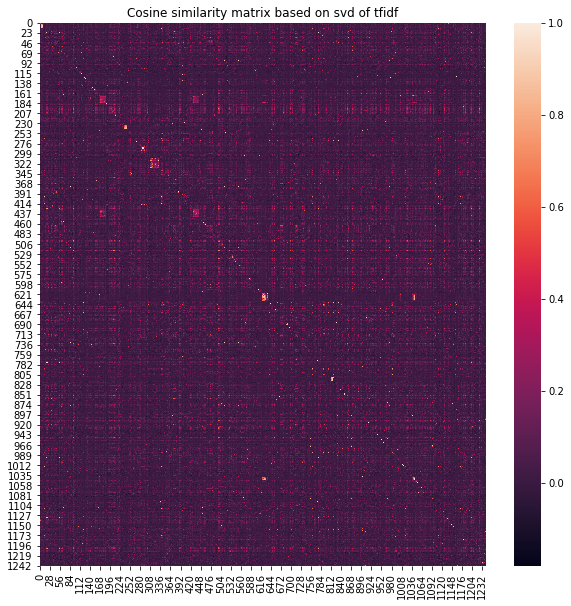

In [220]:
MAX=sim_df.sim.max()
MIN=sim_df.sim.min()

for i in range(len(similarities)):
    cosine_sim_matrix[sim_df.X.iloc[i],sim_df.Y.iloc[i]]=sim_df.sim[i] # enter the similarity and [0,1]
    cosine_sim_matrix[sim_df.Y.iloc[i],sim_df.X.iloc[i]]=sim_df.sim[i] # enter the similarity and [1,0]
    cosine_sim_matrix[sim_df.X.iloc[i],sim_df.X.iloc[i]]=None # leave the diagonals blank
    
plt.figure(figsize=(10,10))
sns.heatmap(cosine_sim_matrix, vmin=MIN,vmax=MAX)
plt.title('Cosine similarity matrix based on svd of tfidf')
plt.show()

In [221]:
# Transform array to matrix
cos_sim_df=pd.DataFrame(data=cosine_sim_matrix)
print(cos_sim_df.shape)

# prepare the labels for the columns and index
Author_Title=[]
for i in range(1244): 
    Author_Title.append(train_df.Author.iloc[i]+'_'+train_df.Title.iloc[i]) 
print(len(Author_Title))

(1244, 1244)
1244


In [222]:
# Label the columns and index of the similarity matrix with Artist and Song
cos_sim_df.columns=Author_Title
cos_sim_df.index=Author_Title

In [225]:
cos_sim_df.to_csv("cos_sim_df.csv")

In [226]:
#Most similar books for a book from the fiction section
cos_sim_df['unknown_the adventures of aladdin'].sort_values(ascending=False).head()

unknown_the fable of ali and the sultan's saddle           0.778746
unknown_the story of the flying trunk                      0.513645
unknown_the story of the parrot shah                       0.478546
unknown_the story of ali baba and the 40 thieves           0.466994
unknown_what files are legal for distribution on a bbs?    0.446359
Name: unknown_the adventures of aladdin, dtype: float64

In [227]:
#Most similar books for a book from the occult section
cos_sim_df['unknown_codes: poems and koans of the jedi'].sort_values(ascending=False).head()

unknown_a deeper analysis of the force                                                                          0.407397
manly p. hall_the lost keys of freemasonry or the secret of hiram abiff                                         0.363723
unknown_mental influence: the jedi mind tricks explained                                                        0.340359
unknown_information on the space shuttle waste collection system                                                0.317344
unknown_freedom from war: the united states program for general and complete disarmament in a peaceful world    0.276866
Name: unknown_codes: poems and koans of the jedi, dtype: float64

In [228]:
#Most similar books for a book from the law section
#A Showdown Over Computer Crime, by Brooks Boliek (August 5, 1990)
cos_sim_df['unknown_section 250.12 of the model penal code: violation of privacy'].sort_values(ascending=False).head()

unknown_electronic communication privacy act: part iii                         0.851716
-laws of the communications security association_                              0.829526
unknown_bibliography on law and computers                                      0.818293
unknown_the vax programs list (1990)                                           0.814362
unknown_information and documents needed for software copyright application    0.772293
Name: unknown_section 250.12 of the model penal code: violation of privacy, dtype: float64

In [230]:
# Most similar book for a book from the programming section
#The 10 Commandments for C Programmers by Henry Spencer
cos_sim_df['lthium of vla_three dimensional shading in computer graphics'].sort_values(ascending=False).head()

trip v. reece _the mathematics of three-dimensional manipulations and transformations    0.554755
max pandaemonium_the mathematics behind perspective,                                     0.513203
d. m. hanna_city chicken,                                                                0.361621
unknown_mathematics of the fractal types                                                 0.348318
unknown_quickbasic tutorial: make a pacman move across the screen!                       0.313785
Name: lthium of vla_three dimensional shading in computer graphics, dtype: float64

In [232]:
# MOst similar book for a book from the survival section
cos_sim_df['unknown_making pine soup'].sort_values(ascending=False).head()

unknown_10 winter driving tips                              0.874322
unknown_south american folk remedy for snakebite            0.842731
unknown_starting fires, from the american survival guide    0.791938
unknown_overview of the survival network                    0.371628
c.e. teal _planning survival,                               0.272995
Name: unknown_making pine soup, dtype: float64

In [233]:
# Most similar book for a book from the programming section
#unknown_the nag-buster (documentation) from erik famm(1994)
cos_sim_df['unknown_the nag-buster (documentation) from erik famm(1994)'].sort_values(ascending=False).head()

ralf brown _public domain/freeware/shareware                                                                 0.781655
clary and kraft_version 1.1 - bbs legal guide                                                                0.302372
unknown_a phreak encounter (story)                                                                           0.251881
unknown_example of a policy regarding bbs downtime                                                           0.222018
unknown_some opinions on leaving your computer on 24 hours a day and mounting your machine sideways, 1990    0.220911
Name: unknown_the nag-buster (documentation) from erik famm(1994), dtype: float64

The recommendation of similar texts using the cosine similarity function works very well. 

# Tagging with 3 most common bow words
As tfidf does not combine lemma,I will use most common bow words for each document for the addition of the most characteristic tag words.

In [240]:
# Transpose the bow_data
bow_T=train_BOWFeatures.T

# Name the columns of the new dataframe using the document title and a running number 
titles=[]
for i, item in enumerate(train_df['Title']):
    titles.append(str(i+1)+'_'+item)

bow_T.columns=titles

# Sort the dataframe by each column and select the 5 most common words.
top1bow=[]
top2bow=[]
top3bow=[]

for c in range(bow_T.shape[1]):
    df_T=bow_T.sort_values(bow_T.columns[c], ascending=False).head()
    top1bow.append(df_T.index[0])
    top2bow.append(df_T.index[1])
    top3bow.append(df_T.index[2])

In [241]:
# Adding the top 5 words to the lsa data
lsa_df['tag1']=top1bow
lsa_df['tag2']=top2bow
lsa_df['tag3']=top3bow

columnsOI=['lsa_2','Author','Title','Cat2','tag1','tag2','tag3']
lsa_df[columnsOI].sort_values(['lsa_2'], ascending=False).head()

,lsa_2,Author,Title,Cat2,tag1,tag2,tag3
270,0.571749,unknown,"computer crime: current practices, problems an...",law,computer,crime,virus
701,0.559846,unknown,"kansas computer crimes law, 1985",law,section,computer,21
100,0.551862,unknown,"arkansas regulations on computer crime, 1987",law,computer,crime,relate
782,0.551215,unknown,the minnesota computer crimes law,law,computer,subd,system
963,0.549858,unknown,"rhode island computer crimes law, 1979",law,computer,access,11


The addition of the three most common words gives a good idea about the doument's content. 

In [266]:
# Plotting the most common words of tag1
top1_tags30=lsa_df[columnsOI].groupby('tag1').count().sort_values('Title', ascending=False).head(100)

In [268]:
top1_tags30['index']=top1_tags30.index

In [273]:
top1_tags30_longwords=top1_tags30
print(top1_tags30_longwords.shape) 
for i, item in enumerate(top1_tags30_longwords['index']):  
    if len(item)<=3:
        top1_tags30_longwords=top1_tags30_longwords.drop(item,axis=0) 
print(top1_tags30_longwords.shape)    

(100, 7)
(67, 7)


In [280]:
top1_tags30_longwords.lsa_2.sum()

296

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),
 <a list of 67 Text xticklabel objects>)

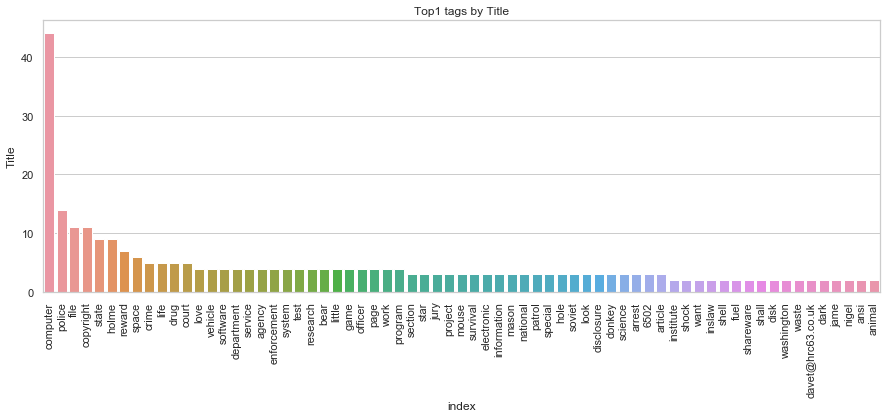

In [277]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,5))
ax = sns.barplot(x="index", y="Title", data=top1_tags30_longwords)
plt.title('Top1 tags by Title')
plt.xticks(rotation=90)